In [1]:
import copy
import random

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DEVICE = 'cuda'

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_data = mnist_trainset.data.unsqueeze(1) / 255
mnist_data = mnist_data.to(DEVICE)
mnist_labels = mnist_trainset.targets.to(DEVICE)
print('Mnist train shape:', mnist_data.shape)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
mnist_test_data = mnist_testset.data.unsqueeze(1) / 255
mnist_test_data = mnist_test_data.to(DEVICE)
mnist_test_labels = mnist_testset.targets.to(DEVICE)
print('Mnist test shape:', mnist_test_data.shape)

mnist_data_tuple = (mnist_data, mnist_labels, mnist_test_data, mnist_test_labels)

# Now do the same for cifar-10
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar_data = torch.from_numpy(cifar_trainset.data).to(DEVICE)
cifar_data = cifar_data.permute(0, 3, 1, 2) / 255
cifar_labels = torch.LongTensor(cifar_trainset.targets).to(DEVICE)
print('Cifar train shape:', cifar_data.shape)

cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
cifar_test_data = torch.from_numpy(cifar_testset.data).to(DEVICE)
cifar_test_data = cifar_test_data.permute(0, 3, 1, 2) / 255
cifar_test_labels = torch.LongTensor(cifar_testset.targets).to(DEVICE)
print('Cifar test shape:', cifar_test_data.shape)

cifar_data_tuple = (cifar_data, cifar_labels, cifar_test_data, cifar_test_labels)

C:\Users\ninja\.conda\envs\ml2\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Mnist train shape: torch.Size([60000, 1, 28, 28])
Mnist test shape: torch.Size([10000, 1, 28, 28])
Files already downloaded and verified
Cifar train shape: torch.Size([50000, 3, 32, 32])
Files already downloaded and verified
Cifar test shape: torch.Size([10000, 3, 32, 32])


In [4]:
# Create simple convnet for MNIST
class MnistConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(32 * 5 * 5, 10))

    def forward(self, x):
        return self.layers(x)

In [5]:
def validate(model, data, labels):
    model.eval()
    with torch.no_grad():
        y_pred = model(data)
        loss = F.cross_entropy(y_pred, labels)
        accuracy = (y_pred.argmax(dim=1) == labels).float().mean()
    model.train()
    return loss.item(), accuracy.item()

# Simple training loop for MNIST
def train_mnist(
        model, data, labels, test_data=None, test_labels=None,
        num_epochs=10, batch_size=1000, lr=0.01, verbose=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_accuracies = []
        for i in range(0, data.shape[0], batch_size):
            x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
            y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)

            y_pred = model(x)
            loss = F.cross_entropy(y_pred, y)
            epoch_losses.append(loss.item())
            accuracy = (y_pred.argmax(dim=1) == y).float().mean()
            epoch_accuracies.append(accuracy.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        valid_loss, valid_acc = validate(model, test_data, test_labels)
        train_losses.append(np.mean(epoch_losses))
        train_accs.append(np.mean(epoch_accuracies))
        val_losses.append(valid_loss)
        val_accs.append(valid_acc)
        if verbose or epoch == num_epochs - 1:
            print('Epoch {}: train loss = {:.3f}, train accuracy = {:.2f}%'.format(
                epoch, np.mean(epoch_losses), np.mean(epoch_accuracies) * 100) \
                + '\n\ttest loss = {:.3f}, test accuracy = {:.2f}%'.format(valid_loss, valid_acc * 100))

    return train_losses, train_accs, val_losses, val_accs
    
# Train the model
model = MnistConvNet().to(DEVICE)
train_mnist(model, *mnist_data_tuple, num_epochs=10, lr=0.01)

<ipython-input-5-016a79ebf43c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-5-016a79ebf43c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 0: train loss = 0.361, train accuracy = 88.57%
	test loss = 0.080, test accuracy = 97.51%
Epoch 1: train loss = 0.063, train accuracy = 98.13%
	test loss = 0.041, test accuracy = 98.65%
Epoch 2: train loss = 0.041, train accuracy = 98.76%
	test loss = 0.042, test accuracy = 98.64%
Epoch 3: train loss = 0.032, train accuracy = 99.04%
	test loss = 0.042, test accuracy = 98.69%
Epoch 4: train loss = 0.026, train accuracy = 99.21%
	test loss = 0.030, test accuracy = 99.01%
Epoch 5: train loss = 0.022, train accuracy = 99.34%
	test loss = 0.036, test accuracy = 98.94%
Epoch 6: train loss = 0.020, train accuracy = 99.37%
	test loss = 0.052, test accuracy = 98.50%
Epoch 7: train loss = 0.021, train accuracy = 99.36%
	test loss = 0.066, test accuracy = 98.05%
Epoch 8: train loss = 0.019, train accuracy = 99.39%
	test loss = 0.048, test accuracy = 98.71%
Epoch 9: train loss = 0.016, train accuracy = 99.47%
	test loss = 0.039, test accuracy = 98.90%


([0.36055571045726537,
  0.06264246307934324,
  0.041276550556843476,
  0.031958541631077725,
  0.026019902310023706,
  0.022055921307764948,
  0.02044342951849103,
  0.02055273427007099,
  0.018519475023883084,
  0.0163556001537169],
 [0.8856500434378783,
  0.9812833786010742,
  0.987550042072932,
  0.9904000441233317,
  0.9920833776394526,
  0.9933500419060389,
  0.9937000433603923,
  0.9935833801825841,
  0.9938833743333817,
  0.9947333772977193],
 [0.08020196855068207,
  0.040833406150341034,
  0.042340826243162155,
  0.042320266366004944,
  0.029882485046982765,
  0.03636326640844345,
  0.05214710533618927,
  0.06583257019519806,
  0.047673434019088745,
  0.03853590413928032],
 [0.9750999808311462,
  0.9864999651908875,
  0.9863999485969543,
  0.9868999719619751,
  0.9900999665260315,
  0.9893999695777893,
  0.98499995470047,
  0.9804999828338623,
  0.9870999455451965,
  0.9889999628067017])

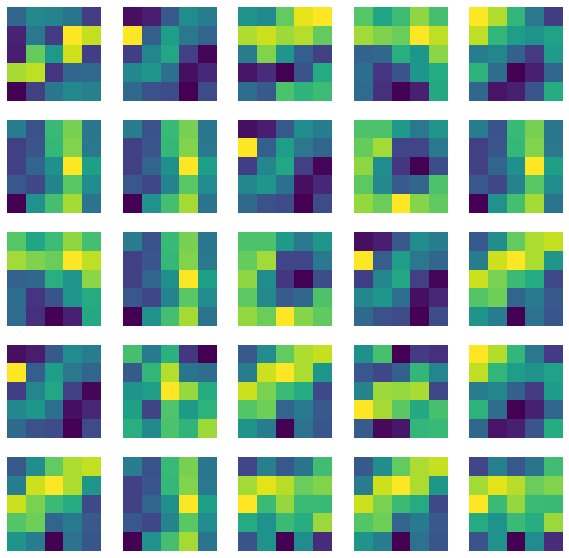

In [6]:
def visualize_filters(weights, sz=5):
    # Visualize the filters in any layer of a conv net
    model.eval()
    with torch.no_grad():
        filters = weights.detach().cpu().numpy()
        filters = filters.reshape(
            filters.shape[0] * filters.shape[1],
            filters.shape[2], filters.shape[3])
        filters = np.squeeze(filters)
        min_val, max_val = filters.min(), filters.max()
        filters = (filters + min_val) / (max_val - min_val)
        filters = np.uint8(filters * 255)
        # draw a grid of size sz x sz, with each entry being a randomly chosen filter
        filters_idxs = np.random.choice(filters.shape[0], size=(sz, sz))
        fig, ax = plt.subplots(sz, sz, figsize=(10, 10))
        for i in range(sz):
            for j in range(sz):
                ax[i, j].imshow(filters[filters_idxs[i, j]])
                ax[i, j].axis('off')
    plt.show()

visualize_filters(model.layers[0].weight)
# visualize_filters(model.layers[3].weight)

## Learning ideas

Types of self-supervised learning
- Contrastive learning


- Learn filters that are maximally different
- Learn filters that lead to non-correlated activations
- Try to reconstruct the input using the filters

## Trying to develop a reverse convolution training method

In [7]:
input_img = mnist_data[0]

n_filters = 16 # 16
filter_sz = 7
stride = 1
padding = 0
filters = torch.empty((n_filters, 1, filter_sz, filter_sz), dtype=torch.float32, device=DEVICE)
nn.init.xavier_uniform(filters)
output_shape = ((input_img.shape[1] - filter_sz + 2 * padding) // stride + 1,
               (input_img.shape[2] - filter_sz + 2 * padding) // stride + 1)
filters.requires_grad = True

# reverse_weights = torch.empty((n_filters, 1, output_size, output_size), dtype=torch.float32, device=DEVICE)
reverse_weights = torch.empty((output_shape[0], output_shape[1], n_filters, 1), dtype=torch.float32, device=DEVICE)
reverse_weights.requires_grad = True
nn.init.xavier_uniform(reverse_weights)


optim = torch.optim.SGD([filters, reverse_weights], lr=1)

## Attempt 1: Doesn't work
# for i in range(200):
#     patch_start = (input_img.shape[-1] - filter_sz) // 2 # 12
#     target_img_patch = input_img[0, patch_start:patch_start+filter_sz, patch_start:patch_start+filter_sz]
#     reversed_output = (filters * reverse_weights[:, :, :1, :1]).sum(dim=0)
#     loss = torch.mean(torch.square(target_img_patch - reversed_output.squeeze()))
#     if i % 5 == 0:
#         print('loss: {:.3f}'.format(loss.item()))

#     optim.zero_grad()
#     loss.backward()
#     optim.step()

## Attempt 3: Couldn't figure out how to get this to work with scattering
# for i in range(100):
#     reversed_outputs = (filters.unsqueeze(0).unsqueeze(0) * reverse_weights.unsqueeze(-1).unsqueeze(-1)).sum(dim=2)
#     reversed_outputs = reversed_outputs.squeeze()
#     # reversed_img = torch.zeros(list(input_img.shape) + [np.prod(reversed_outputs.shape)], dtype=torch.float32, device=DEVICE)
#     # reversed_img_overlap = torch.zeros_like(reversed_img)
#     loss_sum = 0
#     for j in range(0, reversed_outputs.shape[0]):
#         for k in range(0, reversed_outputs.shape[1]):
#             img_idx = (j*stride, k*stride)
#             target_img_patch = input_img[:, img_idx[0]:img_idx[0]+filter_sz, img_idx[1]:img_idx[1]+filter_sz]
#             loss_sum += torch.sum(torch.square(target_img_patch - reversed_outputs[j, k]))
#     loss = loss_sum / (reversed_outputs.shape[0] * reversed_outputs.shape[1])

# Attempt 4: Works and is fast
for i in range(100):
    reversed_outputs = (filters.unsqueeze(0).unsqueeze(0) * reverse_weights.unsqueeze(-1).unsqueeze(-1)).sum(dim=2)
    reversed_outputs = reversed_outputs.squeeze()
    img_patches = []
    for j in range(0, reversed_outputs.shape[0]):
        for k in range(0, reversed_outputs.shape[1]):
            img_idx = (j*stride, k*stride)
            target_img_patch = input_img[:, img_idx[0]:img_idx[0]+filter_sz, img_idx[1]:img_idx[1]+filter_sz]
            img_patches.append(target_img_patch)
    img_patches = torch.stack(img_patches)
    img_patches = img_patches.reshape(*reversed_outputs.shape)

    losses = (reversed_outputs - img_patches) ** 2
    loss = losses.mean([0, 1]).sum()

    if i % 5 == 0:
        print('loss: {:.3f}'.format(loss.item()))

    optim.zero_grad()
    loss.backward()
    optim.step()

<ipython-input-7-8fb426b64a15>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(filters)
<ipython-input-7-8fb426b64a15>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(reverse_weights)


loss: 8.687
loss: 8.653
loss: 8.555
loss: 8.176
loss: 6.912
loss: 4.981
loss: 4.045
loss: 3.410
loss: 2.907
loss: 2.528
loss: 2.213
loss: 1.955
loss: 1.748
loss: 1.577
loss: 1.430
loss: 1.304
loss: 1.199
loss: 1.113
loss: 1.040
loss: 0.974


## Training loop for re-conv

In [8]:
def train_re_conv(
        data, batch_size=1000, epochs=50, lr=1, in_filters=1,
        out_filters=16, filter_sz=5, stride=1, verbose=True):
    # Data should be of shape (n_samples, in_filters, img_sz, img_sz)

    filters = torch.empty((out_filters, in_filters, filter_sz, filter_sz), dtype=torch.float32, device=DEVICE)
    nn.init.xavier_uniform(filters)
    output_shape = ((data.shape[2] - filter_sz + 2 * 0) // stride + 1,
                (data.shape[3] - filter_sz + 2 * 0) // stride + 1)
    filters.requires_grad = True

    # reverse_weights = torch.empty((out_filters, 1, output_size, output_size), dtype=torch.float32, device=DEVICE)
    reverse_weights = torch.empty((output_shape[0], output_shape[1], out_filters, in_filters), dtype=torch.float32, device=DEVICE)
    reverse_weights.requires_grad = True
    nn.init.xavier_uniform(reverse_weights)

    optim = torch.optim.Adam([filters, reverse_weights], lr=lr)
    
    for epoch in range(epochs):
        for i in range(0, data.shape[0], batch_size):
            batch = data[i:i+batch_size]
            reversed_outputs = (filters.unsqueeze(0).unsqueeze(0) * reverse_weights.unsqueeze(-1).unsqueeze(-1)).sum(dim=2)
            reversed_outputs = reversed_outputs.squeeze()
            img_patches = []
            for j in range(0, reversed_outputs.shape[0]):
                for k in range(0, reversed_outputs.shape[1]):
                    img_idx = (j*stride, k*stride)
                    target_img_patch = batch[:, :, img_idx[0]:img_idx[0]+filter_sz, img_idx[1]:img_idx[1]+filter_sz]
                    img_patches.append(target_img_patch)
            img_patches = torch.stack(img_patches, dim=1)
            reversed_outputs = reversed_outputs.reshape(*img_patches.shape[1:])
            losses = (reversed_outputs.unsqueeze(0) - img_patches) ** 2
            loss = losses.mean([0, 1, 2]).sum()

        if (epoch % 1 == 0 and verbose) or epoch == epochs - 1:
            print('Epoch {}\tloss: {:.3f}'.format(epoch, loss.item()))

        optim.zero_grad()
        loss.backward()
        optim.step()
    
    return filters, reversed_outputs

In [9]:
def prep_imshow(tensor):
    return tensor.detach().cpu().numpy().squeeze()

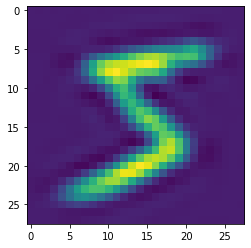

In [84]:
reversed_img = torch.zeros(list(input_img.shape), dtype=torch.float32, device=DEVICE)
reversed_img_overlap = torch.zeros_like(reversed_img)
loss_sum = 0
for j in range(0, reversed_outputs.shape[0]):
    for k in range(0, reversed_outputs.shape[1]):
        img_idx = (j*stride, k*stride)
        reversed_img[0, img_idx[0]:img_idx[0]+filter_sz, img_idx[1]:img_idx[1]+filter_sz] += reversed_outputs[j, k] # , 0]
        reversed_img_overlap[0, img_idx[0]:img_idx[0]+filter_sz, img_idx[1]:img_idx[1]+filter_sz] += 1
        # Need to try rewriting using scatter

plt.imshow(prep_imshow(reversed_img))

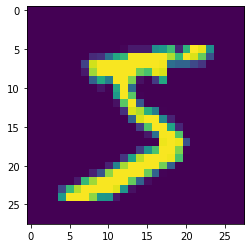

In [85]:
plt.imshow(prep_imshow(input_img))

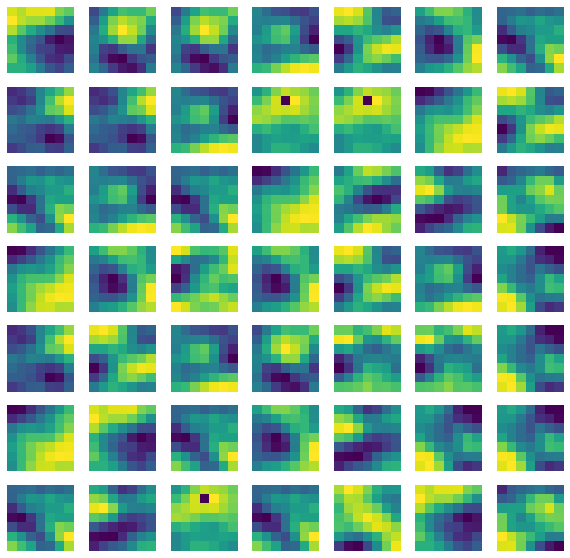

In [52]:
visualize_filters(filters, sz=7)

In [23]:
print(target_img_patch)
print(reversed_output)

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0')


NameError: name 'reversed_output' is not defined

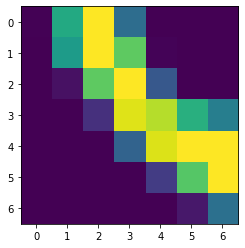

In [192]:
plt.imshow(prep_imshow(target_img_patch))

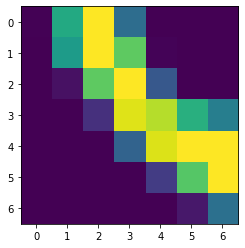

In [193]:
plt.imshow(reversed_output.detach().cpu().numpy().squeeze())

In [10]:
n_filters = 16
filter_sz = 5
stride = 1
padding = 0
new_filters, reversed_outputs = train_re_conv(
    mnist_data, epochs=30, lr=0.1,
    out_filters=n_filters, filter_sz=filter_sz, stride=stride)
visualize_filters(new_filters, sz=5)

<ipython-input-8-eccbb8e04cc4>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(filters)
<ipython-input-8-eccbb8e04cc4>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(reverse_weights)


Epoch 0	loss: 4.096


KeyboardInterrupt: 

In [12]:
class SmallConvNet(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()

        conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten())

        test_input = torch.randn(input_shape).unsqueeze(0)
        out_dim = conv_layers(test_input).shape[1]

        self.layers = nn.Sequential(
            *conv_layers,
            nn.Linear(out_dim, 10))

    def forward(self, x):
        return self.layers(x)

In [102]:
init_model = SmallConvNet()

In [109]:
# Train the model
e2e_model = copy.deepcopy(init_model).to(DEVICE)
train_mnist(e2e_model, *mnist_data_tuple, num_epochs=10, lr=0.01)

<ipython-input-6-44d99d82652b>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-6-44d99d82652b>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 0: train loss = 2.138, train accuracy = 49.91%
	test loss = 1.905, test accuracy = 73.01%
Epoch 1: train loss = 1.565, train accuracy = 75.40%
	test loss = 1.171, test accuracy = 80.24%
Epoch 2: train loss = 0.946, train accuracy = 81.45%
	test loss = 0.733, test accuracy = 84.64%
Epoch 3: train loss = 0.664, train accuracy = 84.73%
	test loss = 0.562, test accuracy = 86.70%
Epoch 4: train loss = 0.543, train accuracy = 86.45%
	test loss = 0.479, test accuracy = 87.96%
Epoch 5: train loss = 0.479, train accuracy = 87.54%
	test loss = 0.432, test accuracy = 88.60%
Epoch 6: train loss = 0.440, train accuracy = 88.23%
	test loss = 0.402, test accuracy = 89.31%
Epoch 7: train loss = 0.414, train accuracy = 88.72%
	test loss = 0.380, test accuracy = 89.73%
Epoch 8: train loss = 0.395, train accuracy = 89.06%
	test loss = 0.364, test accuracy = 90.02%
Epoch 9: train loss = 0.380, train accuracy = 89.34%
	test loss = 0.351, test accuracy = 90.31%


In [107]:
pretrained_model = copy.deepcopy(init_model).to(DEVICE)
with torch.no_grad():
    pretrained_model.layers[0].weight.data = new_filters
pretrained_model.layers[0].weight.requires_grad = False
train_mnist(pretrained_model, *mnist_data_tuple, num_epochs=10, lr=0.01)

<ipython-input-6-44d99d82652b>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-6-44d99d82652b>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 0: train loss = 1.451, train accuracy = 70.65%
	test loss = 0.974, test accuracy = 83.07%
Epoch 1: train loss = 0.846, train accuracy = 83.59%
	test loss = 0.710, test accuracy = 86.12%
Epoch 2: train loss = 0.674, train accuracy = 85.67%
	test loss = 0.598, test accuracy = 87.39%
Epoch 3: train loss = 0.589, train accuracy = 86.81%
	test loss = 0.534, test accuracy = 88.20%
Epoch 4: train loss = 0.537, train accuracy = 87.53%
	test loss = 0.491, test accuracy = 88.70%
Epoch 5: train loss = 0.500, train accuracy = 88.04%
	test loss = 0.461, test accuracy = 89.17%
Epoch 6: train loss = 0.473, train accuracy = 88.48%
	test loss = 0.438, test accuracy = 89.58%
Epoch 7: train loss = 0.452, train accuracy = 88.80%
	test loss = 0.420, test accuracy = 89.96%
Epoch 8: train loss = 0.436, train accuracy = 89.07%
	test loss = 0.405, test accuracy = 90.20%
Epoch 9: train loss = 0.422, train accuracy = 89.28%
	test loss = 0.392, test accuracy = 90.40%


<ipython-input-86-184f6af8e8b5>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(filters)
<ipython-input-86-184f6af8e8b5>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(reverse_weights)


Epoch 0	loss: 3.932
Epoch 1	loss: 3.746
Epoch 2	loss: 2.455
Epoch 3	loss: 1.409
Epoch 4	loss: 1.298
Epoch 5	loss: 1.087
Epoch 6	loss: 0.882
Epoch 7	loss: 0.880
Epoch 8	loss: 0.745
Epoch 9	loss: 0.548
Epoch 10	loss: 0.504
Epoch 11	loss: 0.533
Epoch 12	loss: 0.474
Epoch 13	loss: 0.396
Epoch 14	loss: 0.373
Epoch 15	loss: 0.354
Epoch 16	loss: 0.318
Epoch 17	loss: 0.292
Epoch 18	loss: 0.275
Epoch 19	loss: 0.253
Epoch 20	loss: 0.230
Epoch 21	loss: 0.216
Epoch 22	loss: 0.202
Epoch 23	loss: 0.188
Epoch 24	loss: 0.178
Epoch 25	loss: 0.172
Epoch 26	loss: 0.162
Epoch 27	loss: 0.149
Epoch 28	loss: 0.139
Epoch 29	loss: 0.130
Epoch 30	loss: 0.121
Epoch 31	loss: 0.114
Epoch 32	loss: 0.113
Epoch 33	loss: 0.110
Epoch 34	loss: 0.103
Epoch 35	loss: 0.097
Epoch 36	loss: 0.093
Epoch 37	loss: 0.090
Epoch 38	loss: 0.088
Epoch 39	loss: 0.085
Epoch 40	loss: 0.082
Epoch 41	loss: 0.079
Epoch 42	loss: 0.077
Epoch 43	loss: 0.075
Epoch 44	loss: 0.073
Epoch 45	loss: 0.071
Epoch 46	loss: 0.070
Epoch 47	loss: 0.068
Ep

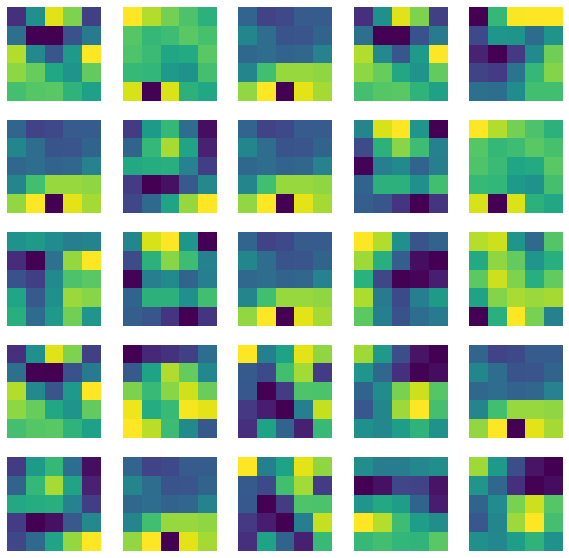

In [113]:
n_pretrain_samples = 1
filters_n_1, reversed_outputs = train_re_conv(
    mnist_data[:n_pretrain_samples], epochs=100, lr=0.1,
    out_filters=n_filters, filter_sz=filter_sz, stride=stride)
visualize_filters(filters_n_1, sz=5)

In [127]:
pretrained_model_2 = copy.deepcopy(init_model).to(DEVICE)
with torch.no_grad():
    pretrained_model_2.layers[0].weight.data = filters_n_1
pretrained_model_2.layers[0].weight.requires_grad = False
train_mnist(pretrained_model_2, *mnist_data_tuple, num_epochs=10, lr=0.01)

<ipython-input-117-7e6c1b1b02d9>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-117-7e6c1b1b02d9>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 0: train loss = 0.981, train accuracy = 78.16%
	test loss = 0.575, test accuracy = 87.33%
Epoch 1: train loss = 0.523, train accuracy = 87.65%
	test loss = 0.443, test accuracy = 89.39%
Epoch 2: train loss = 0.436, train accuracy = 89.15%
	test loss = 0.388, test accuracy = 90.39%
Epoch 3: train loss = 0.393, train accuracy = 89.93%
	test loss = 0.356, test accuracy = 90.96%
Epoch 4: train loss = 0.366, train accuracy = 90.38%
	test loss = 0.335, test accuracy = 91.41%
Epoch 5: train loss = 0.347, train accuracy = 90.79%
	test loss = 0.319, test accuracy = 91.73%
Epoch 6: train loss = 0.332, train accuracy = 91.14%
	test loss = 0.306, test accuracy = 92.06%
Epoch 7: train loss = 0.320, train accuracy = 91.45%
	test loss = 0.296, test accuracy = 92.24%
Epoch 8: train loss = 0.310, train accuracy = 91.67%
	test loss = 0.288, test accuracy = 92.36%
Epoch 9: train loss = 0.302, train accuracy = 91.85%
	test loss = 0.280, test accuracy = 92.58%


## Function to easily run experiments

In [13]:
def run_experiment(
        model_cls,
        train_data,
        pretrain = False,
        pretrain_data = None,
        n_train_epochs = 10,
        n_pretrain_epochs = 20,
        train_lr = 0.001,
        pretrain_lr = 0.1,
        freeze_weights = False,
        visualize_weights = False,
        model_kwargs = {},
        seed = 42,
        graph = False):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    model = model_cls(**model_kwargs).to(DEVICE)
    if pretrain:
        out_filters = model.layers[0].weight.shape[0]
        filter_sz = model.layers[0].weight.shape[2]
        stride = model.layers[0].stride[0]
        pretrain_weights, _ = train_re_conv(
            pretrain_data, epochs=n_pretrain_epochs, lr=pretrain_lr,
            out_filters=out_filters, filter_sz=filter_sz, stride=stride, verbose=False)
        if visualize_weights:
            visualize_filters(pretrain_weights, sz=5)

        with torch.no_grad():
            model.layers[0].weight.data = pretrain_weights
    if freeze_weights:
        model.layers[0].weight.requires_grad = False
    
    _, train_accs, _, valid_accs = train_mnist(model, *train_data, num_epochs=n_train_epochs, lr=train_lr, verbose=False)

    if graph:
        plt.plot(train_accs, label='train')
        plt.plot(valid_accs, label='valid')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.show()

### Experiments

<ipython-input-213-016a79ebf43c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-213-016a79ebf43c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 9: train loss = 0.073, train accuracy = 97.99%
	test loss = 0.065, test accuracy = 98.12%


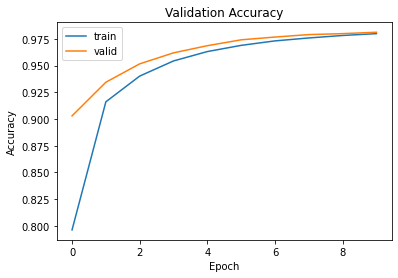

In [228]:
# No pretraining baseline
run_experiment(SmallConvNet, mnist_data_tuple, freeze_weights=False, graph=True)

<ipython-input-213-016a79ebf43c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-213-016a79ebf43c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 9: train loss = 0.180, train accuracy = 95.10%
	test loss = 0.171, test accuracy = 95.40%


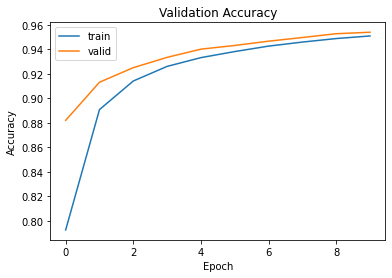

In [215]:
# No pretraining, frozen weights
run_experiment(SmallConvNet, mnist_data_tuple, freeze_weights=True, graph=True)

<ipython-input-128-eccbb8e04cc4>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(filters)
<ipython-input-128-eccbb8e04cc4>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(reverse_weights)


Epoch 19	loss: 2.408


<ipython-input-213-016a79ebf43c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-213-016a79ebf43c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 9: train loss = 0.182, train accuracy = 94.80%
	test loss = 0.171, test accuracy = 95.18%


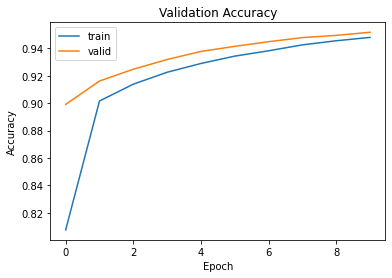

In [216]:
# Pretraining, frozen weights
run_experiment(
    SmallConvNet, mnist_data_tuple, pretrain=True,
    pretrain_data=mnist_data, freeze_weights=True, graph=True)

<ipython-input-128-eccbb8e04cc4>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(filters)
<ipython-input-128-eccbb8e04cc4>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(reverse_weights)


Epoch 19	loss: 2.408


<ipython-input-213-016a79ebf43c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-213-016a79ebf43c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 9: train loss = 0.067, train accuracy = 98.09%
	test loss = 0.063, test accuracy = 98.19%


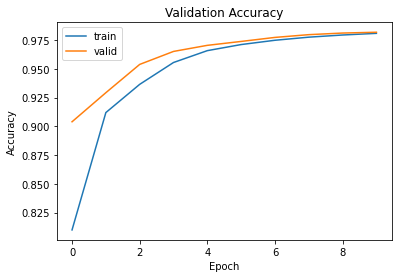

In [217]:
# Pretraining, trainable weights
run_experiment(
    SmallConvNet, mnist_data_tuple, pretrain=True,
    pretrain_data=mnist_data, freeze_weights=False, graph=True)

<ipython-input-128-eccbb8e04cc4>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(filters)
<ipython-input-128-eccbb8e04cc4>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(reverse_weights)


Epoch 19	loss: 0.273


<ipython-input-213-016a79ebf43c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-213-016a79ebf43c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 9: train loss = 0.115, train accuracy = 96.89%
	test loss = 0.112, test accuracy = 96.99%


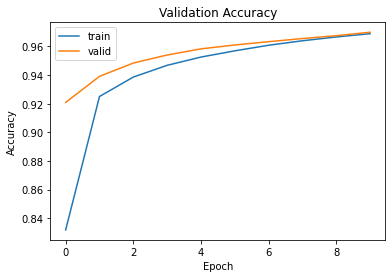

In [218]:
# Pretraining, single sample
run_experiment(
    SmallConvNet, mnist_data_tuple, pretrain=True,
    pretrain_data=mnist_data[:1], freeze_weights=True,
    n_pretrain_epochs=20, graph=True)

<ipython-input-128-eccbb8e04cc4>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(filters)
<ipython-input-128-eccbb8e04cc4>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(reverse_weights)


Epoch 19	loss: 2.188


<ipython-input-213-016a79ebf43c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-213-016a79ebf43c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 9: train loss = 0.172, train accuracy = 95.08%
	test loss = 0.162, test accuracy = 95.38%


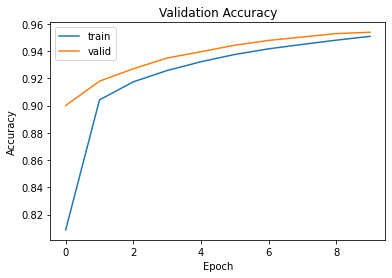

In [219]:
# Pretraining, 100 samples
run_experiment(
    SmallConvNet, mnist_data_tuple, pretrain=True,
    pretrain_data=mnist_data[:100], freeze_weights=True,
    n_pretrain_epochs=20, graph=True)

<ipython-input-213-016a79ebf43c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-213-016a79ebf43c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 1999: train loss = 0.000, train accuracy = 100.00%
	test loss = 2.106, test accuracy = 70.82%


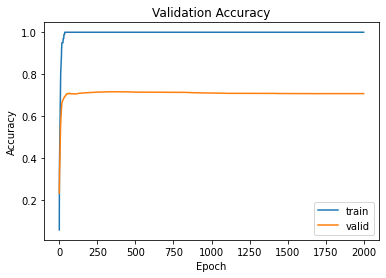

In [220]:
# Small training set
run_experiment(
    SmallConvNet, (mnist_data[:100], mnist_labels[:100], mnist_test_data, mnist_test_labels),
    freeze_weights=False, pretrain=False, n_train_epochs=2000, graph=True)

<ipython-input-128-eccbb8e04cc4>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(filters)
<ipython-input-128-eccbb8e04cc4>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(reverse_weights)


Epoch 19	loss: 0.273


<ipython-input-213-016a79ebf43c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-213-016a79ebf43c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 1999: train loss = 0.000, train accuracy = 100.00%
	test loss = 1.718, test accuracy = 70.79%


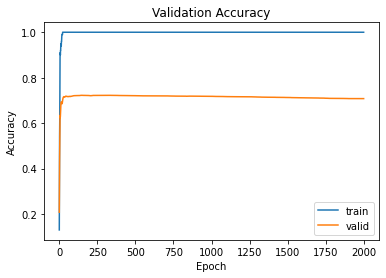

In [221]:
# Pretraining & small training set
run_experiment(
    SmallConvNet, (mnist_data[:100], mnist_labels[:100], mnist_test_data, mnist_test_labels),
    pretrain=True, pretrain_data=mnist_data[:1], freeze_weights=True,
    n_pretrain_epochs=20, n_train_epochs=2000, graph=True)

<ipython-input-128-eccbb8e04cc4>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(filters)
<ipython-input-128-eccbb8e04cc4>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(reverse_weights)


Epoch 19	loss: 2.408


<ipython-input-213-016a79ebf43c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-213-016a79ebf43c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 1999: train loss = 0.000, train accuracy = 100.00%
	test loss = 1.813, test accuracy = 71.29%


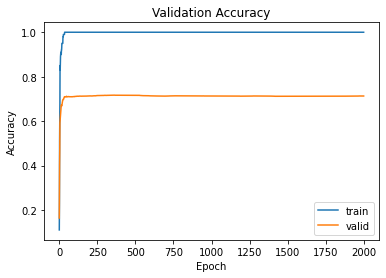

In [222]:
# Pretraining & small training set
run_experiment(
    SmallConvNet, (mnist_data[:100], mnist_labels[:100], mnist_test_data, mnist_test_labels),
    pretrain=True, pretrain_data=mnist_data, freeze_weights=True,
    n_pretrain_epochs=20, n_train_epochs=2000, graph=True)

## CIFAR-10 Experiments

In [15]:
cifar_args = {'model_kwargs': {'input_shape': (3, 32, 32)}}

<ipython-input-5-016a79ebf43c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-5-016a79ebf43c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 39: train loss = 1.014, train accuracy = 65.48%
	test loss = 1.126, test accuracy = 61.10%


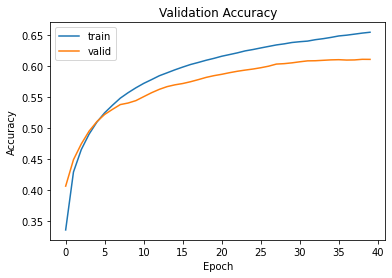

In [16]:
# No pretraining baseline
run_experiment(
    SmallConvNet, cifar_data_tuple, freeze_weights=False,
    n_train_epochs=40, graph=True, **cifar_args)

<ipython-input-5-016a79ebf43c>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(data[i:i+batch_size], dtype=torch.float32)
<ipython-input-5-016a79ebf43c>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(labels[i:i+batch_size], dtype=torch.long)


Epoch 39: train loss = 1.267, train accuracy = 56.96%
	test loss = 1.338, test accuracy = 53.62%


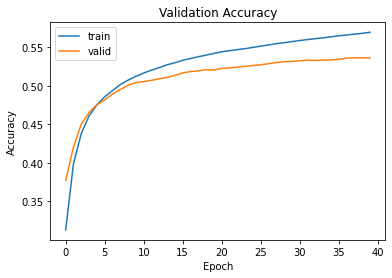

In [17]:
# No pretraining, random weights
run_experiment(
    SmallConvNet, cifar_data_tuple, freeze_weights=True,
    n_train_epochs=40, graph=True, **cifar_args)

In [20]:
# Pretraining, frozen weights
run_experiment(
    SmallConvNet, cifar_data_tuple, pretrain=True,
    pretrain_data=cifar_data, freeze_weights=True,
    graph=True, **cifar_args)

<ipython-input-8-eccbb8e04cc4>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(filters)
<ipython-input-8-eccbb8e04cc4>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(reverse_weights)


RuntimeError: shape '[784, 3, 5, 5]' is invalid for input of size 19600